# Fun with Forecasting
### 4 February 2022

Lunch and learn -- let's explore some options on how to address timeseries analysis.

Here, I'm going to use a real but relatively basic dataset that tracks energy usage in various parts of the United States (Ohio). 

Before we start, there are a few basic concepts to cover:

## Stationarity

A dataset is said to be **stationary** if it does not show periodic trends or seasonality -- all trends are due to outside forces and noise, and not due to predictable adjustments over time. The goal of most time series modeling is to take a non-stationary wave, derive the components leading to periodicity, and predict the data from remaining sources. As we might expect, energy usage is definitely not stationairy.

The primary means of creating stationary data is to perform **differencing**. Differencing is literally the measure at time $t$ subtracted by the measurement at time $t-1$. This necessarially interrupts the autocorrelation of the data between time intervales. Multiple levels of differencing may be necessary for data with a lag component (e.g., data at $t-3$ influences data at time $t$). 

## Seasonality

A dataset is said to be **seasonal** if it shows predictable fluctuations by regular time unites that are non-sequential but repeating. Temperature fluctuations in temparate global regions are an obvious example. While average temperature at day $t$ is autocorrelated with temperature at time $t-1$, the data will still demonstrate a curvilinear pattern after differencing due to the longer-term fluctuations in temperature caused by the tilt of the Earth's axis. Seasonality adjustment corrects for such repeating factors.

## Getting Started

I'm going to progress through a series of models that can be used for forecasting, starting simple and getting more complex. We'll talk through each method and the commplexity tradeoffs as we go.

This data looks at hourly data usage. For the sake of not depressing the pants off of everyone, I'm going to start by compressing this data to weekly rates. This will (A) be faster and (B) only have a single seasonal component by year without the daily and weekly seasonality that is so, so much harder to deal with. I'll come back at the end to talk about how we might go about model triple seasonality, though.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from pytz import timezone

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

%matplotlib inline

In [2]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
# ignore jedi issues prevent tab complete
%config Completer.use_jedi = False

## Data Imports

Pandas was literally built for time series data -- PANel DAta is a term for time series analyses in econometrics. There are a few cool tricks for letting pandas know the type of time data you're dealing with along the axes.

In [4]:
# we can automatically parse objects as datetimes through pandas
# setting the datetime as index is very preferred
raw_df = pd.read_csv('../datasets/AEP_hourly.csv', parse_dates = True, index_col='Datetime')

# make sure all the data is in order
raw_df = raw_df.sort_index()

In [5]:
raw_df.shape

(121273, 1)

In [6]:
# unfortunately, pandas cannot interpret the frequency of the data
# this is likely because of missing data at some point
print(pd.infer_freq(raw_df.index))

None


In [7]:
# this appears to be due to three duplicate entries
print(raw_df.index.is_unique)
raw_df.index.shape, raw_df.index.drop_duplicates().shape

# so we drop duplicates
raw_df = raw_df.loc[~raw_df.index.duplicated(), :]
print(raw_df.index.is_unique)

False
True


In [8]:
# we STILL can't use this axis with a set frequency because it's missing values
# so we have to create a new axis that includes null values for missing hours
# and we'll give this axis an hourly frequency
comp_idx = raw_df.asfreq('H').index

In [9]:
# we merge the raw data into our imputed index
# this will leave null values for missing indecies, which we'll fill later
fix_df = pd.DataFrame(index=comp_idx).join(raw_df, how='left')
print(fix_df.index.freq)
print(fix_df.isnull().sum())
raw_df = fix_df

<Hour>
AEP_MW    27
dtype: int64


In [10]:
# giving our target a clearer name
raw_df = raw_df.rename({'AEP_MW':'Load'}, axis=1)

# and adding useful labels for visualization
raw_df['Weekday'] = raw_df.index.day_name()
raw_df['Month'] = raw_df.index.month_name()
raw_df['Year'] = raw_df.index.year

In [11]:
# create a copy with interpolated missing values
inter_df = raw_df.copy(deep=True)
inter_df['Load'] = inter_df.Load.interpolate()

In [12]:
inter_df.isnull().sum()

Load       0
Weekday    0
Month      0
Year       0
dtype: int64

In [38]:
# resampling to be weekly interval data
# based on mean data for the week interval, starting every Monday
# this will remove "Weekday" and "Month" data, which we can easily add back
week_df = inter_df.resample('W-MON').mean()
week_df['Month'] = week_df.index.month_name()
week_df.head()

,Load,Year,Month
Datetime,,,
2004-10-04,13446.400000,2004.0,October
2004-10-11,13879.845238,2004.0,October
2004-10-18,14316.702381,2004.0,October
2004-10-25,14026.547619,2004.0,October
2004-11-01,13885.657738,2004.0,November


# Visualize Data

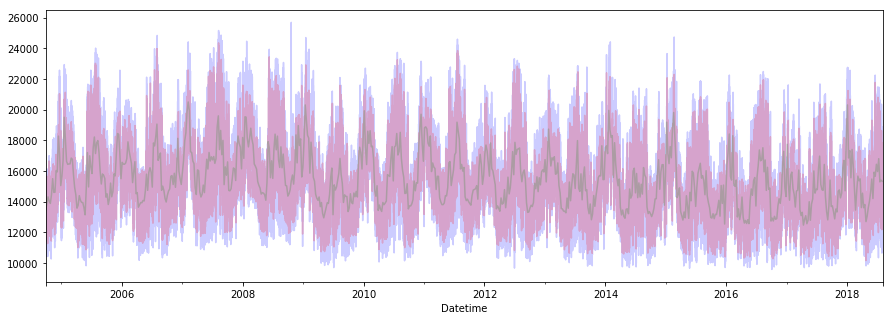

In [36]:
# all data
ax = inter_df.Load.plot(figsize=(15,5), color='blue', alpha=.2);
# every 12th hour (1 AM / 1 PM)
ax = inter_df.iloc[::12, :]['Load'].plot(figsize=(15,5), ax=ax, color='red', alpha=.2);
# every week
ax = week_df['Load'].plot(figsize=(15,5), ax=ax, color='green', alpha=.2);

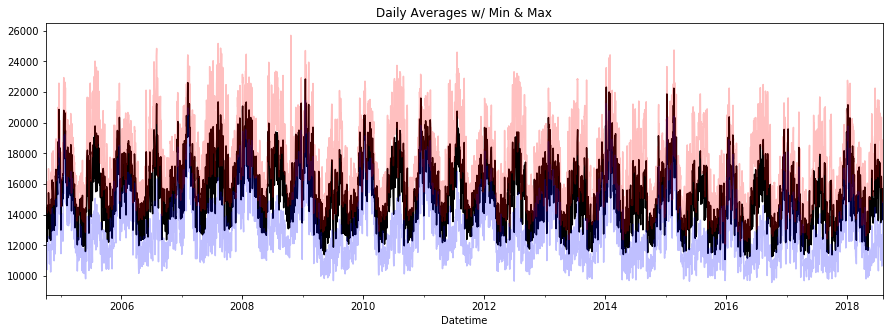

In [19]:
# daily averages with min and max
ax = raw_df.resample('D')['Load'].mean().plot(figsize=(15,5), color='k', title='Daily Averages w/ Min & Max');
inter_df.resample('D')['Load'].min().plot(figsize=(15,5), color='b', alpha=.25, ax=ax);
inter_df.resample('D')['Load'].max().plot(figsize=(15,5), color='r', alpha=.25, ax=ax);

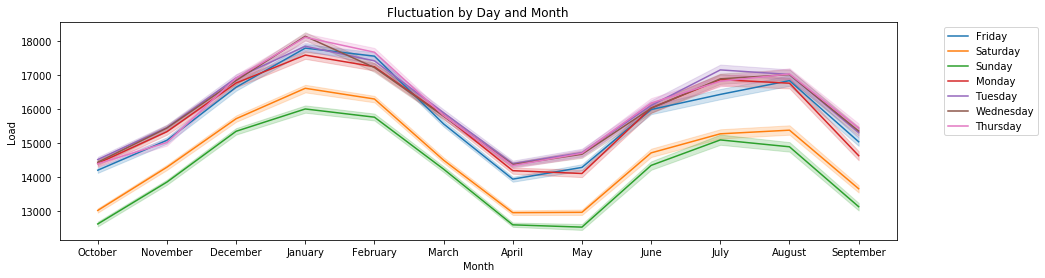

In [21]:
plt.figure(figsize = (15,4))
fig = sns.lineplot(data=inter_df, x="Month", hue='Weekday', y="Load")
fig.set(title = 'Fluctuation by Day and Month')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show();

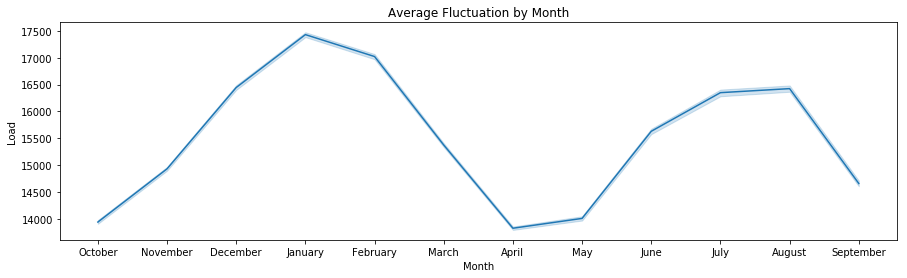

In [43]:
plt.figure(figsize = (15,4))
fig = sns.lineplot(data=inter_df, x="Month", y="Load")
fig.set(title = 'Average Fluctuation by Month')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show();

# Test/Train Split

When conducting splits on timeseries data, it's best to clip off a the last time interval of the rough distance you'd like to predict forward in time. You need to have several cycles of data leading to the point of forecasting to pick up the pattern. We have plenty here, **but** I can already tell from the data above that 2018 saw a noticeable increase from the declines of 2011-2017. Looking at this further we see that this is because the data is not complete to the end of the year.

In [45]:
week_df.index.min(), week_df.index.max(), week_df.shape

(Timestamp('2004-10-04 00:00:00', freq='W-MON'),
 Timestamp('2018-08-06 00:00:00', freq='W-MON'),
 (723, 3))

Given this, we're going to predict six months into the future. This is a nice compromize that maximizes the data for training but still gives us good insight into the future.

In [46]:
train_df = week_df[week_df.index < datetime(2018, 2, 3)]
test_df =  week_df[week_df.index >= datetime(2018, 2, 3)]

In [47]:
# double checking frequency
train_df.index.freq

<Week: weekday=0>

# Exponential Smoothing

Basically all you're doing here is taking a rolling average of the data and poinging it to the future. If your data is simple enough, this is a decent way to go. 

Additive smoothing can be **additive**, meaning that it's a linear increase over time, or **multiplicative**, meaning that we're seeing an exponential raise over time. Looking at our graphs above, Load appears relatively stable year to year, with seasonal fluctuations. We're going to go with additive for now.

We also have to specify our seasonal periods. For now, I'm going with 24hr periods (this ignores weekly and monthly periods). As we will see, this falls off within a couple days to just be a mess of a standing wave.

In [48]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [49]:
print(test_df.index.min())
print(test_df.index.max())

2018-02-05 00:00:00
2018-08-06 00:00:00


In [80]:
fitted_model = ExponentialSmoothing(train_df['Load'],
                                    trend='add', 
                                    seasonal='add', 
                                    seasonal_periods=52, #yearly
                                    damped_trend=True
                                   ).fit()

# forecasting  years into the future
ES_predictions = fitted_model.forecast(steps=test_df.shape[0])

/opt/anaconda3/envs/lbdev/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


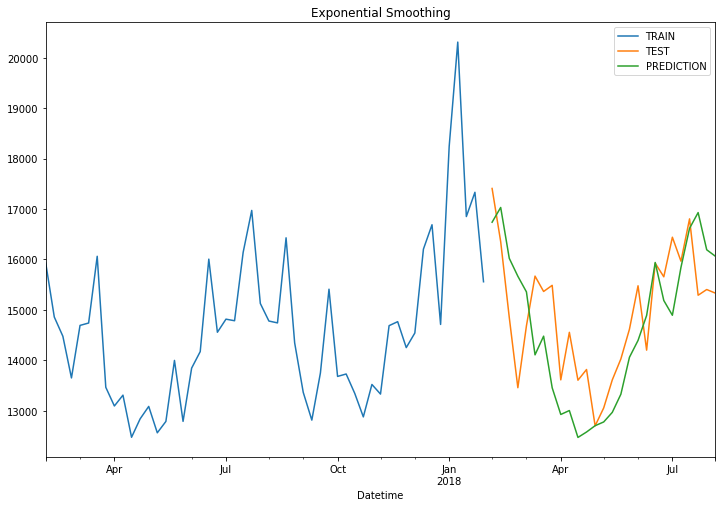

In [81]:
# only showing a year previous to give us a feel for the trend
train_df.loc[train_df.index[-52:]]['Load'].plot(legend=True,
                        label='TRAIN',
                        figsize=(12,8), title='Exponential Smoothing');
test_df['Load'].plot(legend=True,
                       label='TEST', figsize=(12,8));

ES_predictions.plot(legend=True, 
                      label='PREDICTION');



### Evaluation

Honestly, not bad for basically applying a rolling average that includes information from the previous year. 

In [84]:
ES_preds = ES_predictions

In [82]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(test_df.Load, ES_predictions)
mae = mean_absolute_error(test_df.Load, ES_predictions)
rmse = np.sqrt(mean_squared_error(test_df.Load, ES_predictions))

print(f'R2: {r2 :.4f}\t MAE: {mae :.4f}\t RMSE: {rmse :.4f}')

R2: 0.1899	 MAE: 886.7925	 RMSE: 1056.0728


# Looking at Autocorrelation

Simple exponential smoothing won't work because we have a very, very non-stationary dataset. We'll need to perform differencing and lag differencing in order to get anything to work at this granularity.

In [57]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

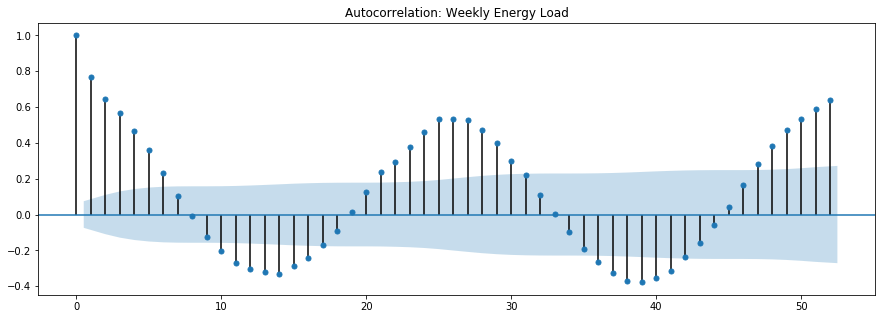

In [58]:
# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation: Weekly Energy Load'
lags = 52
fig, ax = plt.subplots(figsize=(15,5))
ax = plot_acf(train_df.Load,title=title,lags=lags, ax=ax);

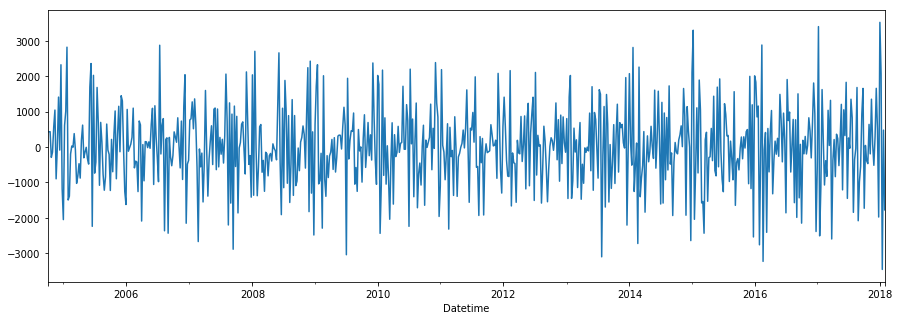

In [59]:
from statsmodels.tsa.statespace.tools import diff

train_df['d1'] = diff(train_df['Load'],k_diff=1)
train_df['d1'].plot(figsize=(15,5));

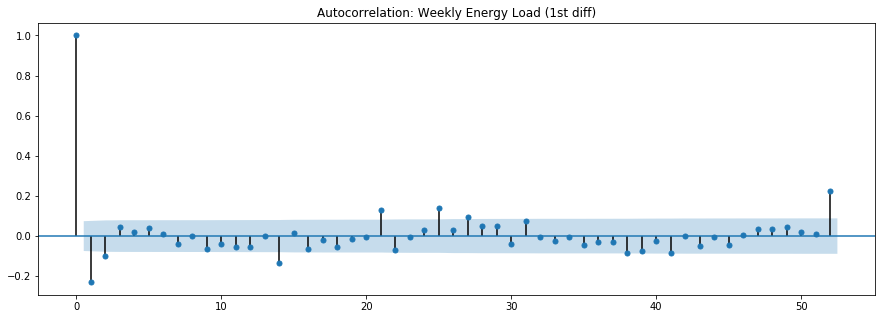

In [63]:
# Autocorrelation of the first difference
# we mostly eliminate autocorrelation, although we still see some residual correlation
# at the 1st lag of the first difference
# so it's worth trying a second difference
title = 'Autocorrelation: Weekly Energy Load (1st diff)'
lags = 52
fig, ax = plt.subplots(figsize=(15,5))
ax = plot_acf(train_df.d1.dropna(),title=title,lags=lags, ax=ax);

In [65]:
# pandas has a built-in diff that uses the scipy under the hood
# we can use this for the second diff
train_df['d2'] = train_df.d1.diff(1)

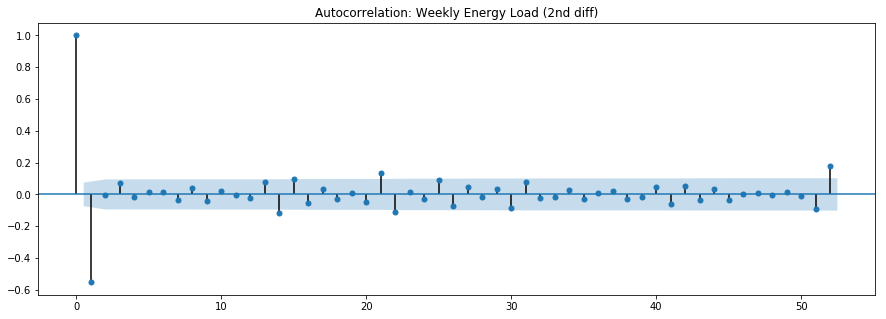

In [67]:
# Autocorrelation of the second difference

# well, well, well, would you look at that
# rather than chase differences into eternity, we can automate this parameter

title = 'Autocorrelation: Weekly Energy Load (2nd diff)'
lags = 52
fig, ax = plt.subplots(figsize=(15,5))
ax = plot_acf(train_df.d2.dropna(),title=title,lags=lags, ax=ax);

# Autoregressive Model

Judging from the autocorrelation, we can probably build an AR model that does a fair job with relatively low complexity. The real question is the degree of differencing necessary for a good model. Let's see!

In [68]:
from statsmodels.tsa.ar_model import AR,ARResults

In [70]:
model = AR(train_df['Load'])
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const      3568.043011
L1.Load       0.769959
dtype: float64


In [71]:
start=len(train_df)
end=len(train_df)+len(test_df)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Load Predictions')

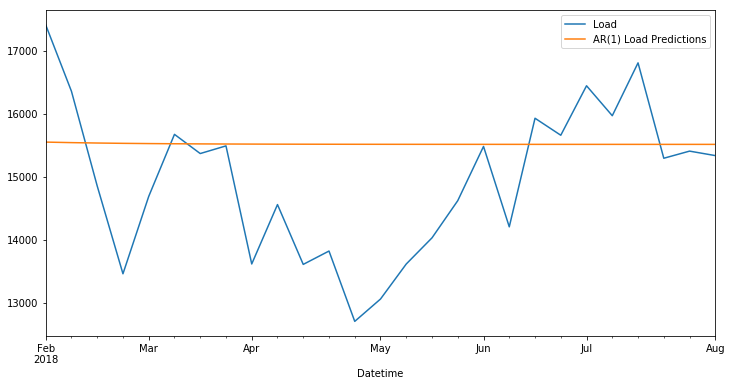

In [72]:
# at least we regress to the mean pretty smoothly
test_df['Load'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

## Fitting an AR(2) Model

In [73]:
model = AR(train_df['Load'])
AR2fit = model.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
Coefficients:
const      3102.306465
L1.Load       0.668600
L2.Load       0.131367
dtype: float64


In [74]:
start=len(train_df)
end=len(train_df)+len(test_df)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Load Predictions')

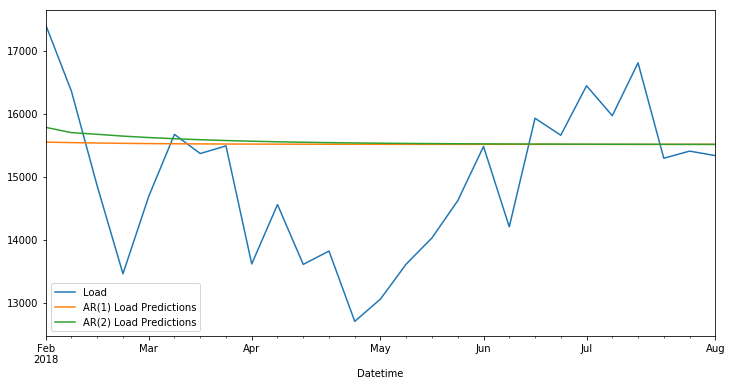

In [75]:
# at least we regress to the mean pretty smoothly
test_df.loc[test_df.index[0:200]]['Load'].plot(legend=True)
predictions1.loc[predictions1.index[0:200]].plot(legend=True,figsize=(12,6));
predictions2.loc[predictions2.index[0:200]].plot(legend=True,figsize=(12,6));

## Getting Statsmodels to predict AR lag values


In [76]:
model = AR(train_df['Load'])
ARfit = model.fit(method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 19
Coefficients:
const       3464.475303
L1.Load        0.580225
L2.Load        0.056618
L3.Load        0.145621
L4.Load        0.047449
L5.Load        0.065750
L6.Load       -0.005263
L7.Load       -0.055902
L8.Load       -0.003816
L9.Load       -0.081619
L10.Load      -0.015772
L11.Load      -0.040610
L12.Load      -0.011819
L13.Load       0.025614
L14.Load      -0.104600
L15.Load       0.079208
L16.Load      -0.061347
L17.Load       0.045677
L18.Load      -0.014736
L19.Load       0.125938
dtype: float64


In [77]:
start = len(train_df)
end = len(train_df)+len(test_df)-1
rename = f'AR(19) Predictions'

predictions19 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

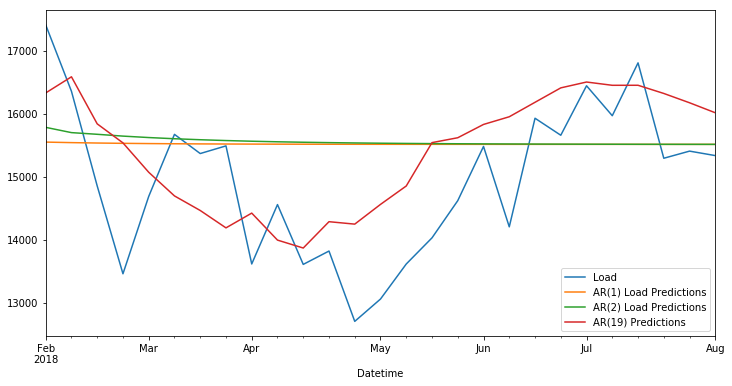

In [78]:
test_df['Load'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions19.plot(legend=True,figsize=(12,6));

### evaluation

It's clear that even when we autoregress with a large lag, there's a seasonal component that cannot be captured by an AR model alone. Even then, this is a pretty good improvement over a rolling average!

In [83]:
AR_preds = predictions19

In [89]:
def print_metrics(y, pred, label=''):
    r2 = r2_score(y, pred)
    mae = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))
    print(f'{label}')
    print(f'R2: {r2 :.4f}\t MAE: {mae :.4f}\t RMSE: {rmse :.4f}\n')


In [91]:
print_metrics(test_df.Load, ES_preds, label='ES Predictions')
print_metrics(test_df.Load, AR_preds, label='AR(19) Predictions')

ES Predictions
R2: 0.1899	 MAE: 886.7925	 RMSE: 1056.0728

AR(19) Predictions
R2: 0.2709	 MAE: 863.1265	 RMSE: 1001.8899



# Fitting an Autoregressive Integrated Moving Average (ARIMA) Model

Normally I'd start by passing in an ARMA model, but we already know that we'll need an integration because of the autoregression above. For review, an ARIMA is the workhorse of time series models. Most other ts analyses are variations off this. ARIMA is *not perfectly suited for all time series analyses*. For example, stock prices have so many outside factors that time doesn't actually factor into nearly as much as other market forces. But it is fantastic when time is a strong IV of your measurement. 

So, ARIMA is powerful, but not magic. A big part is understanding data completely before applying. As a result, there are a lot of types of ARIMA. 

* Atoregressive moving average (ARMA)
* Non-seasonal ARIMA
* Seasonal ARIMA (SARIMA)
* Exogenous Variable SARIMA (SARIMAX) - takes additional parameters (P,D,Q) to identify seasonal trends.

Arima models are applied where data shows some evidence of nonstationarity, where an initial differencing step (the "integrated" part of the name) can be applied one or more times to eliminate that non-stationarity. We previously programmed out differencing, but ARIMA does it as par for the course. 

Non-seasonal ARIMA models are generally denoted as ARIMA(p,d,q):
* AR - p - Autoregression - what we've focused on so far. The correlation of time t to a previous time component. 
* I - d - integration - differencing of observations to make the time series stationary
* MA - q - Moving Average - uses dependency between an observation and residual error from a moving average model applied to lagged observations

So, what is stationarity? It's the status of a time series indicating if it is stationary. A stationary dataset has constant mean and variance over time. Practically, this means we cannot have a trend in our dataset (no increases or declines). Variance should also not be a function of time (should not get more or less erratic over time). 

The Augmented Dickey-Fuller test is a good method of identifying stationarity in our models. 

Methods of selecting hyperparameters:
* Method One - use Autocorrelation plots and eyeballing p,d,q based on decay. These plots are pretty difficult to read, and don't necessarially lead to the ideal hyperparameters
* Method Two - grid search -- run a bunch of ARIMA models on combinations of p,d, and q. This is linearly slower, but you are more likely to find the most accurate model.

I'm going with method two here because I'm lazy. It's worthwhile to note that our training data is freaking huge for running a complete grid search, so I'm only going to take a year's worth of data. I'm also going to cheat and use this nifty package, `pmdarima`, to grid search for us.

Also note that there's a pretty obvious seasonal component to this data. I'm going to create a model without seasonal component first to compare to the seasonal ARIMA (SARIMA) we'll make next.

In [92]:
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults
from pmdarima import auto_arima # for determining ARIMA orders

In [93]:
auto_arima(train_df['Load']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  696
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -5843.682
Date:                Mon, 18 Apr 2022   AIC                          11697.364
Time:                        14:36:30   BIC                          11720.084
Sample:                             0   HQIC                         11706.149
                                - 696                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0652      0.120      8.873      0.000       0.830       1.300
ar.L2         -0.4613      0.086     -5.393      0.000      -0.629      -0.294
ma.L1         -1.3260      0.114    -11.637      0.000      -1.549      -1.103
ma.L2          0.6638      0.077      8.658      0.000       0.513       0.814
sigma2       1.19e+06   6.25e+04     19.034      0.000    1.07e+06    1.31e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.65   Prob(JB):                         0.50
Heteroskedasticity (H):               1.16   Skew:                             0.00
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [126]:
#NOTE invertability
# an invertable process is a one in which recent observations have higher weight than distant observations
# this enforces the process for theta weight to be less than 1 (weight to recent observations)
# when you get an error about non-invertible starting MA parameters, this means
# that you might get a model weighted more heavily to the past
arima_orders = (2,1,2)
model = ARIMA(train_df['Load'],order=arima_orders)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Load   No. Observations:                  695
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5823.672
Method:                       css-mle   S.D. of innovations           1050.872
Date:                Mon, 18 Apr 2022   AIC                          11659.345
Time:                        16:56:33   BIC                          11686.608
Sample:                    10-11-2004   HQIC                         11669.887
                         - 01-29-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.1274      0.951     -2.236      0.025      -3.992      -0.263
ar.L1.D.Load     0.8774      0.152      5.777      0.000       0.580       1.175
ar.L2.D.Load    -0.0360      0.119     -0.303      0.762      -0.269       0.197
ma.L1.D.Load    -1.2239      0.146     -8.362      0.000      -1.511      -0.937
ma.L2.D.Load     0.2239      0.146      1.530      0.126      -0.063       0.511
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1988           +0.0000j            1.1988            0.0000
AR.2           23.1468           +0.0000j           23.1468            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            4.4663           +0.0000j            4.4663            0.0000
-----------------------------------------------------------------------------
"""

In [105]:
# Obtain predicted values
start=train_df.shape[0]
end=start+test_df.shape[0]-1
# we need to include a few parameters to convert differenced predeictions back to the same
# level as the input
predictions = results.predict(start=start, 
                              end=end, 
                              dynamic=False, 
                              typ='levels').rename('ARIMA(2,1,2) Predictions')

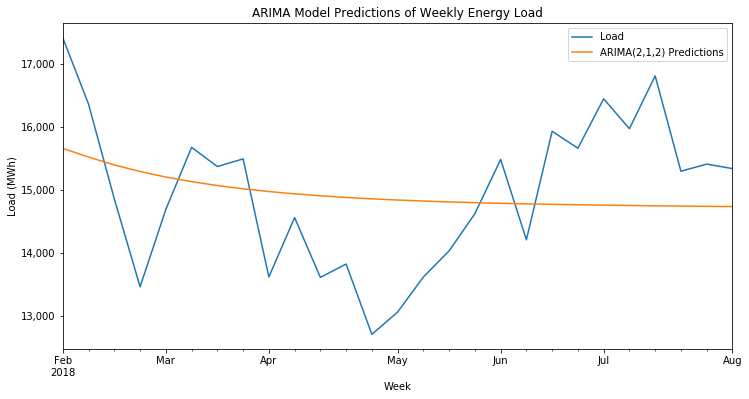

In [106]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'ARIMA Model Predictions of Weekly Energy Load'
ylabel='Load (MWh)'
xlabel='Week' 

ax = test_df['Load'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### evaluation

Looking OK, but there's definitely a missing seasonal component.

In [99]:
ARIMA_preds = predictions

In [100]:
print_metrics(test_df.Load, ES_preds, label='ES Predictions')
print_metrics(test_df.Load, AR_preds, label='AR(19) Predictions')
print_metrics(test_df.Load, ARIMA_preds, label='ARIMA(2,1,2) Predictions')

ES Predictions
R2: 0.1899	 MAE: 886.7925	 RMSE: 1056.0728

AR(19) Predictions
R2: 0.2709	 MAE: 863.1265	 RMSE: 1001.8899

ARIMA(2,1,2) Predictions
R2: 0.0419	 MAE: 1003.2365	 RMSE: 1148.5258



# SARIMA

Seasonal ARIMA -- same as before, but with additional parameters for the seasonal component.


In [120]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [116]:
train_df.groupby('Year').count()

,Load,Month,d1,d2
Year,,,,
2004,14,14,13,12
2005,52,52,52,52
2006,52,52,52,52
2007,52,52,52,52
2008,53,53,53,53
2009,52,52,52,52
2010,52,52,52,52
2011,52,52,52,52
2012,52,52,52,52


In [133]:
# working with a seasonal component of 52 weeks (yearly)
# this will take a LONG TIME
auto_model = auto_arima(train_df['Load'],seasonal=True,m=52)

In [134]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  696
Model:             SARIMAX(4, 1, 0)x(0, 0, [1, 2], 52)   Log Likelihood               -5817.180
Date:                                 Mon, 18 Apr 2022   AIC                          11648.360
Time:                                         17:18:08   BIC                          11680.167
Sample:                                              0   HQIC                         11660.659
                                                 - 696                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3238      0.034     -9.417      0.000      -0.391      -0.256
ar.L2         -0.2436      0.035     -6.872      0.000      -0.313      -0.174
ar.L3         -0.0925      0.039     -2.383      0.017      -0.169      -0.016
ar.L4         -0.0395      0.036     -1.093      0.274      -0.110       0.031
ma.S.L52       0.2399      0.031      7.805      0.000       0.180       0.300
ma.S.L104      0.1504      0.038      3.991      0.000       0.077       0.224
sigma2      1.066e+06   5.53e+04     19.274      0.000    9.58e+05    1.17e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 2.04
Prob(Q):                              0.79   Prob(JB):                         0.36
Heteroskedasticity (H):               1.09   Skew:                             0.10
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
model = SARIMAX(endog=train_df.Load, 
                 order=auto_model.order, 
                 seasonal_order=auto_model.seasonal_order,
                 enforce_inverability=False
       )
results = model.fit()

In [159]:
# Obtain predicted values
start=train_df.shape[0]
end=start+test_df.shape[0]-1
predictions = results.predict(start=start, 
                              end=end, 
                              dynamic=False, 
                              typ='levels').rename(f'SARIMA{model.order}x{model.seasonal_order} Predictions')

In [143]:
# Obtain predicted values
start=train_df.shape[0]
end=start+test_df.shape[0]-1
predictions = results.predict(start=start, 
                              end=end, 
                              dynamic=False, 
                              typ='levels').rename(f'SARIMA{auto_model.order}x{auto_model.seasonal_order} Predictions')

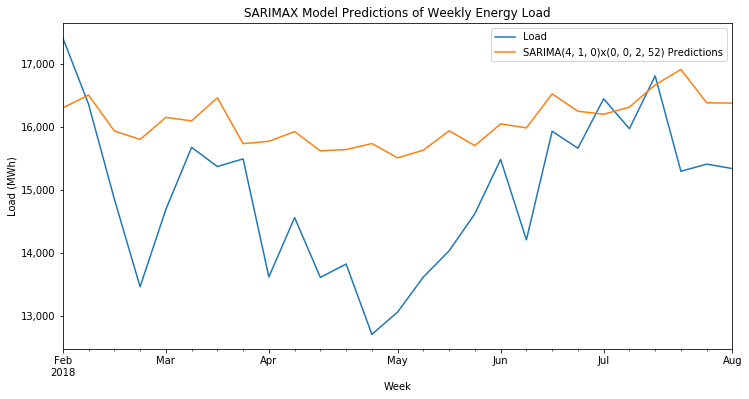

In [160]:
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'SARIMAX Model Predictions of Weekly Energy Load'
ylabel='Load (MWh)'
xlabel='Week' 

ax = test_df['Load'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### evaluation

Well, this is dumb. It doesn't appear to be differencing by the seasonal component (D=0), nor does it appear to be autoregression over seasons. I'm going to manually force something to see what happens.

In [161]:
SARIMA_preds = predictions

In [164]:
print_metrics(test_df.Load, ES_preds, label='ES Predictions')
print_metrics(test_df.Load, AR_preds, label='AR(19) Predictions')
print_metrics(test_df.Load, ARIMA_preds, label='ARIMA(2,1,2) Predictions')
print_metrics(test_df.Load, SARIMA_preds, label=f'SARIMA{model.order}x{model.seasonal_order}')

ES Predictions
R2: 0.1899	 MAE: 886.7925	 RMSE: 1056.0728

AR(19) Predictions
R2: 0.2709	 MAE: 863.1265	 RMSE: 1001.8899

ARIMA(2,1,2) Predictions
R2: 0.0419	 MAE: 1003.2365	 RMSE: 1148.5258

SARIMA(4, 1, 0)x(0, 0, 2, 52)
R2: -0.5682	 MAE: 1244.0313	 RMSE: 1469.3779



### Intuitive SARIMA

Not sure what's going on with `auto_arima`, but that model does not make intuitive sense. Let's do some manual digging.

In [151]:
model1 = SARIMAX(endog=train_df.Load, 
                 order=(2,1,2), 
                 seasonal_order=(1,1,1,52),
                 enforce_inverability=False
       )
result1 = model1.fit()

In [152]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 Load   No. Observations:                  696
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood               -5344.340
Date:                              Mon, 18 Apr 2022   AIC                          10702.680
Time:                                      17:26:53   BIC                          10733.943
Sample:                                  10-04-2004   HQIC                         10714.812
                                       - 01-29-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6565      0.052    -12.662      0.000      -0.758      -0.555
ar.L2          0.3433      0.038      9.013      0.000       0.269       0.418
ma.L1          0.0951      0.070      1.350      0.177      -0.043       0.233
ma.L2         -0.9049      0.065    -13.912      0.000      -1.032      -0.777
ar.S.L52       0.0829      0.055      1.510      0.131      -0.025       0.191
ma.S.L52      -0.8103      0.049    -16.411      0.000      -0.907      -0.714
sigma2      8.795e+05   1.66e-07    5.3e+12      0.000     8.8e+05     8.8e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.22
Prob(Q):                              0.97   Prob(JB):                         0.20
Heteroskedasticity (H):               1.24   Skew:                             0.09
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.82e+28. Standard errors may be unstable.
"""

In [154]:
# Obtain predicted values

SARIMA_preds2 = result1.predict(start=start, 
                              end=end, 
                              dynamic=False, 
                              typ='levels').rename(f'SARIMA{model1.order}x{model1.seasonal_order} Predictions')

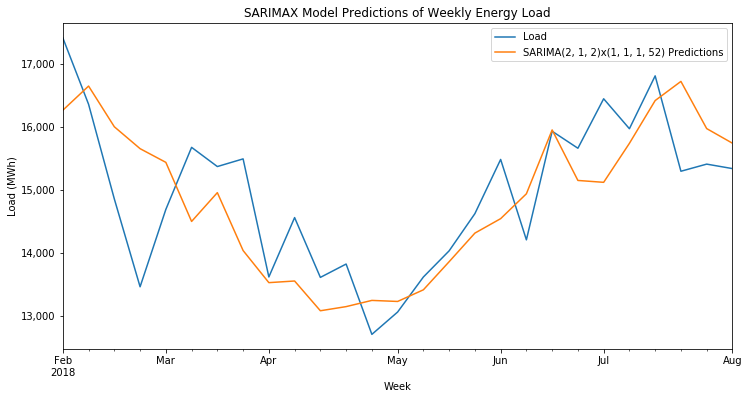

In [166]:
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'SARIMAX Model Predictions of Weekly Energy Load'
ylabel='Load (MWh)'
xlabel='Week' 

ax = test_df['Load'].plot(legend=True,figsize=(12,6),title=title)
SARIMA_preds2.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Manual SARIMA evaluation

Muuuuuuuch better. In practice, we would set up a hyperparamter search (which is what `auto_arima` does in theory. For now, let's just keep rolling.

In [165]:
print_metrics(test_df.Load, ES_preds, label='ES Predictions')
print_metrics(test_df.Load, AR_preds, label='AR(19) Predictions')
print_metrics(test_df.Load, ARIMA_preds, label='ARIMA(2,1,2) Predictions')
print_metrics(test_df.Load, SARIMA_preds, label='SARIMA(4, 1, 0)x(0, 0, 2, 52)')
print_metrics(test_df.Load, SARIMA_preds2, label=f'SARIMA{model1.order}x{model1.seasonal_order} Predictions')

ES Predictions
R2: 0.1899	 MAE: 886.7925	 RMSE: 1056.0728

AR(19) Predictions
R2: 0.2709	 MAE: 863.1265	 RMSE: 1001.8899

ARIMA(2,1,2) Predictions
R2: 0.0419	 MAE: 1003.2365	 RMSE: 1148.5258

SARIMA(4, 1, 0)x(0, 0, 2, 52)
R2: -0.5682	 MAE: 1244.0313	 RMSE: 1469.3779

SARIMA(2, 1, 2)x(1, 1, 1, 52) Predictions
R2: 0.4579	 MAE: 696.5439	 RMSE: 863.9279



# SARIMAX

This is the same thing as a SARIMA model, except that we'll be including some categorical variables as exogenous predictors above and beyond the timeseries. This will almost certainly help, since there are predictable swings in energy usage by things like weather and season.

In [184]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Point, Daily

In [219]:
def get_weather_data(df, interval='W-MON', location=None, plot=False):
    if not location:
        # the AEP data we're using is based out of Columbus, OH
        # so we'll focus on weather there
        location = Point(39.9612, -82.9988, 70)
    
    # Set time period
    start = df.index.min()
    end = df.index.max()

    # Get daily data for 2018
    wdf = Daily(location, start, end)
    wdf = wdf.fetch()
    
    wcols = ['tavg','tmin','tmax','prcp']
    monthly_weather = wdf.resample(interval)[wcols].mean()
    
    if plot:
        # Plot line chart including average, minimum and maximum temperature
        wdf.plot(y=['tavg', 'tmin', 'tmax'], figsize=(15,5))
        plt.show()
    
    output = df.join(monthly_weather)
    
    if output.tavg.isna().sum():
        output = output.loc[output['tavg'].dropna().index]
        
    if output.prcp.isna().sum():
        output.prcp.fillna(0, inplace=True)
    
    return output
    

In [220]:
train_ex = get_weather_data(train_df)

In [222]:
train_ex.head()

,Load,Year,Month,d1,d2,tavg,tmin,tmax,prcp
Datetime,,,,,,,,,
2005-01-03,15050.577381,2004,January,-2049.886905,-874.119048,12.950000,12.000000,13.500000,0.0
2005-01-10,15663.547619,2005,January,612.970238,2662.857143,4.566667,2.666667,7.500000,0.0
2005-01-17,16679.178571,2005,January,1015.630952,402.660714,0.700000,-4.333333,4.833333,0.0
2005-01-24,19506.273810,2005,January,2827.095238,1811.464286,-8.066667,-13.166667,-3.833333,0.0
2005-01-31,18011.523810,2005,January,-1494.750000,-4321.845238,-1.750000,-7.000000,2.333333,0.0


In [223]:
train_ex.index.freq

<Week: weekday=0>

In [224]:
model = SARIMAX(endog=train_ex.Load, 
                 order=(2,1,2), 
                 seasonal_order=(1,1,1,52),
                 enforce_inverability=False,
                exog = train_ex[wcols]
       )
result = model.fit()

In [225]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 Load   No. Observations:                  683
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood               -5210.683
Date:                              Tue, 19 Apr 2022   AIC                          10443.366
Time:                                      11:19:19   BIC                          10492.269
Sample:                                  01-03-2005   HQIC                         10462.361
                                       - 01-29-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tavg        -132.7064     36.677     -3.618      0.000    -204.591     -60.821
tmin          -3.7645      4.795     -0.785      0.432     -13.162       5.633
tmax          57.2857     34.095      1.680      0.093      -9.539     124.111
prcp          31.6280     17.678      1.789      0.074      -3.020      66.276
ar.L1          1.3574      0.058     23.547      0.000       1.244       1.470
ar.L2         -0.3576      0.043     -8.340      0.000      -0.442      -0.274
ma.L1         -1.9053      0.060    -31.852      0.000      -2.023      -1.788
ma.L2          0.9054      0.054     16.743      0.000       0.799       1.011
ar.S.L52      -0.0490      0.047     -1.047      0.295      -0.141       0.043
ma.S.L52      -0.7909      0.041    -19.393      0.000      -0.871      -0.711
sigma2      7.964e+05      0.001   8.14e+08      0.000    7.96e+05    7.96e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.31   Jarque-Bera (JB):                 2.67
Prob(Q):                              0.13   Prob(JB):                         0.26
Heteroskedasticity (H):               1.08   Skew:                            -0.02
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.24e+25. Standard errors may be unstable.
"""

In [226]:
# get testing data
test_ex = get_weather_data(test_df)

#verify we've maintained index frequency
print(test_ex.index.freq)

<Week: weekday=0>


### evaluation -- SARIMAX

SARIMAX is super finicky, because you have to have all exogenous variables accounted for when predicting the future. If you don't have that, you'll need to do some PDQs and/or have fun with VAR models.

In [228]:
start = len(train_ex)
end = len(train_ex) + len(test_ex) - 1
SARIMAX_preds = result.predict(start, end, exog=test_ex[wcols]).rename('SARIMAX Model')

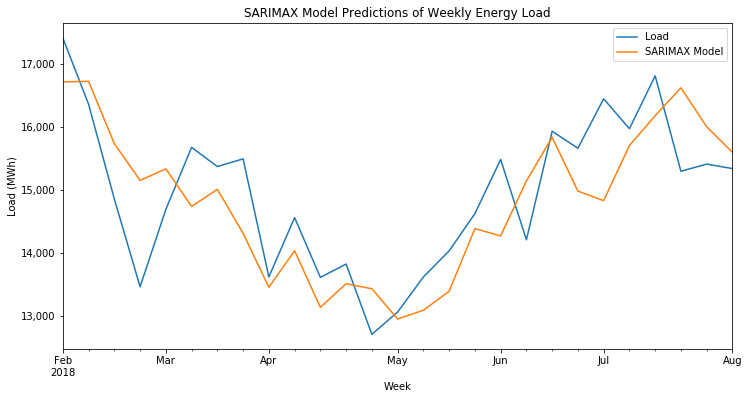

In [230]:
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'SARIMAX Model Predictions of Weekly Energy Load'
ylabel='Load (MWh)'
xlabel='Week' 

ax = test_df['Load'].plot(legend=True,figsize=(12,6),title=title)
SARIMAX_preds.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [229]:
print_metrics(test_df.Load, ES_preds, label='ES Predictions')
print_metrics(test_df.Load, AR_preds, label='AR(19) Predictions')
print_metrics(test_df.Load, ARIMA_preds, label='ARIMA(2,1,2) Predictions')
print_metrics(test_df.Load, SARIMA_preds, label='SARIMA(4, 1, 0)x(0, 0, 2, 52)')
print_metrics(test_df.Load, SARIMA_preds2, label=f'SARIMA{model1.order}x{model1.seasonal_order} Predictions')
print_metrics(test_df.Load, SARIMAX_preds, label=f'SARIMAX Predictions')

ES Predictions
R2: 0.1899	 MAE: 886.7925	 RMSE: 1056.0728

AR(19) Predictions
R2: 0.2709	 MAE: 863.1265	 RMSE: 1001.8899

ARIMA(2,1,2) Predictions
R2: 0.0419	 MAE: 1003.2365	 RMSE: 1148.5258

SARIMA(4, 1, 0)x(0, 0, 2, 52)
R2: -0.5682	 MAE: 1244.0313	 RMSE: 1469.3779

SARIMA(2, 1, 2)x(1, 1, 1, 52) Predictions
R2: 0.4579	 MAE: 696.5439	 RMSE: 863.9279

SARIMAX Predictions
R2: 0.5415	 MAE: 669.9015	 RMSE: 794.5143



# Revision -- 4/18

By popular demand, people have requested follow-ups to the original presentation, where we discuss options for more granular data. As an extra bonus, I've included suggestions on how to approach the problem using a neural network.

# Daily Data

There are ways to model timeseries at a more granular timescale which incorporates multiple seasonality. 

On the most intuitive route, it's entirely possible to make an ensemble of predictors at each timescale. This has the unfortunate consequence of compounding your error term, which generaly means your model isn't going to do so hot. But you can do that!

On a more bespoke manner, it's also possible to manually construct a GLM with polynomial featues to account for predictable seasonal components. It's also not very adviseable, as it will effectively map a very tailored sine wave to your data (which works better than you'd like to see, but still isn't great.

Getting to the actual all-in-one modeling formats, you can try building a seasonal model for the lowest level of granularity, and adding fourier transforms as exogenous variables to account for higher-order seasonal componets. It takes a lot of familiarity with the data and intuitive sense for how the data will flow, so it's for cases when you're allowed to tinker into infinity.

Lastly, I've heard about TBATS (Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components), but I haven't done much independent research on it. From [this cool Medium article](https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a) by the authors of the `tbats` package, it seems worth checking out in the future. 

# SARIMAX with Fourier Terms

Going to stick with daily terms. It's still double seasonality though, so get off my back.

In [238]:
daily_df = inter_df.resample('D').mean()

In [241]:
# prepare Fourier terms
daily_df['sin365'] = np.sin(2 * np.pi * daily_df.index.dayofyear / 365.25)
daily_df['cos365'] = np.cos(2 * np.pi * daily_df.index.dayofyear / 365.25)
daily_df['sin365_2'] = np.sin(4 * np.pi * daily_df.index.dayofyear / 365.25)
daily_df['cos365_2'] = np.cos(4 * np.pi * daily_df.index.dayofyear / 365.25)
train_daily = daily_df[daily_df.index < datetime(2018, 2, 3)]
test_daily = daily_df[daily_df.index >= datetime(2018, 2, 3)]

In [247]:
ex_cols = daily_df.columns.drop(['Load','Year']).tolist()

In [248]:
# Fit model to the weekly seasonal component
# and use exogneous varibles to compute yearly seasonal component
auto_model = auto_arima(y=train_daily.Load, exogenous=train_daily[ex_cols], seasonal=True, m=7)


In [256]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 4873
Model:             SARIMAX(5, 1, 0)x(2, 0, 0, 7)   Log Likelihood              -39608.684
Date:                           Tue, 19 Apr 2022   AIC                          79241.369
Time:                                   12:01:06   BIC                          79319.264
Sample:                               10-01-2004   HQIC                         79268.706
                                    - 02-02-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin365       135.2042   1067.415      0.127      0.899   -1956.892    2227.300
cos365       498.6739   1806.632      0.276      0.783   -3042.259    4039.607
sin365_2    1165.3519    670.981      1.737      0.082    -149.748    2480.451
cos365_2    1187.1107    686.801      1.728      0.084    -158.995    2533.216
ar.L1          0.1867      0.012     15.179      0.000       0.163       0.211
ar.L2         -0.2910      0.013    -22.634      0.000      -0.316      -0.266
ar.L3         -0.0783      0.013     -6.195      0.000      -0.103      -0.054
ar.L4         -0.0897      0.013     -7.124      0.000      -0.114      -0.065
ar.L5         -0.1004      0.013     -7.863      0.000      -0.125      -0.075
ar.S.L7        0.2706      0.012     22.965      0.000       0.248       0.294
ar.S.L14       0.3218      0.012     26.532      0.000       0.298       0.346
sigma2      6.697e+05   1.08e+04     61.982      0.000    6.49e+05    6.91e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               308.30
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.09
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [286]:
daily_model = SARIMAX(endog=train_daily.Load, 
                      order=auto_model.order, 
                      seasonal_order=(4, 0, 0, 7),
#                  seasonal_order=auto_model.seasonal_order,
                      enforce_inverability=False,
                      exog = train_daily[ex_cols]
                     )
daily_result = daily_model.fit()

In [287]:
# Forecast
start=len(train_daily)
end = start+len(test_daily)-1
daily_preds = daily_result.predict(start, end, exog=test_daily[ex_cols])


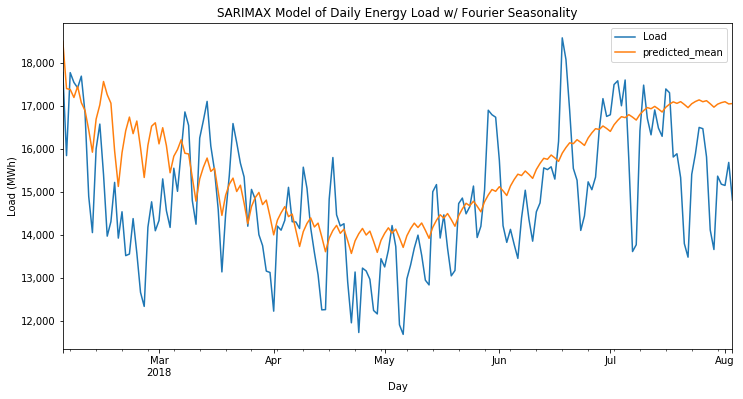

In [292]:
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'SARIMAX Model of Daily Energy Load w/ Fourier Seasonality'
ylabel='Load (MWh)'
xlabel='Day' 

ax = test_daily['Load'].plot(legend=True,figsize=(12,6),title=title)
daily_preds.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [294]:
print_metrics(test_df.Load, ES_preds, label='ES Predictions')
print_metrics(test_df.Load, AR_preds, label='AR(19) Predictions')
print_metrics(test_df.Load, ARIMA_preds, label='ARIMA(2,1,2) Predictions')
print_metrics(test_df.Load, SARIMA_preds, label='SARIMA(4, 1, 0)x(0, 0, 2, 52)')
print_metrics(test_df.Load, SARIMA_preds2, label=f'SARIMA{model1.order}x{model1.seasonal_order} Predictions')
print_metrics(test_df.Load, SARIMAX_preds, label=f'SARIMAX Predictions')
print_metrics(test_daily.Load, daily_preds, label=f'SARIMAX Daily-Level Predictions')

ES Predictions
R2: 0.1899	 MAE: 886.7925	 RMSE: 1056.0728

AR(19) Predictions
R2: 0.2709	 MAE: 863.1265	 RMSE: 1001.8899

ARIMA(2,1,2) Predictions
R2: 0.0419	 MAE: 1003.2365	 RMSE: 1148.5258

SARIMA(4, 1, 0)x(0, 0, 2, 52)
R2: -0.5682	 MAE: 1244.0313	 RMSE: 1469.3779

SARIMA(2, 1, 2)x(1, 1, 1, 52) Predictions
R2: 0.4579	 MAE: 696.5439	 RMSE: 863.9279

SARIMAX Predictions
R2: 0.5415	 MAE: 669.9015	 RMSE: 794.5143

SARIMAX Daily-Level Predictions
R2: 0.1522	 MAE: 1076.7697	 RMSE: 1352.6021



# Bonus Bonus -- RNN Solution

You can also see if a neural network can figure out the patterns in your data. I do know how the kids love their neural networks.

Here's I'm using a simple recurrent neural network (RNN) with an LSTM node. The LSTM node "remembers" data from previous timepoints, which weights predictions on the current time, $t$, by weights learned from $t-k$ timepoints, with weight decreasing over time.

Because neural networks have issues with exploding gradients, it's best for us to scale the data before fitting the model (this is also true for all previous models, but matters more here). We'll then build our neural network using a sequential `keras` model with one LSTM layer and an output layer. Note that this will take a very, very long time on a CPU.

In [299]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df[['Load']])

MinMaxScaler()

In [301]:
scaled_train = scaler.transform(train_df[['Load']])
scaled_test = scaler.transform(test_df[['Load']])

In [306]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [310]:
# create generator for processing such large data
# n_input corresponds to how many time intervals back we are collecting
# going with 52 (weeks/year)
n_input = 52
generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=n_input, batch_size=1)

In [311]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [312]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [313]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [315]:
# run for 10 epochs 
# as you can see, this takes a hot second
model.fit_generator(generator,epochs=10)

Epoch 1/10
644/644 [==============================] - 487s 757ms/step - loss: 0.0295
Epoch 2/10
644/644 [==============================] - 493s 766ms/step - loss: 0.0180
Epoch 3/10
644/644 [==============================] - 551s 856ms/step - loss: 0.0174
Epoch 4/10
644/644 [==============================] - 537s 835ms/step - loss: 0.0174
Epoch 5/10
644/644 [==============================] - 508s 789ms/step - loss: 0.0172
Epoch 6/10
644/644 [==============================] - 528s 820ms/step - loss: 0.0160
Epoch 7/10
644/644 [==============================] - 552s 858ms/step - loss: 0.0167
Epoch 8/10
644/644 [==============================] - 551s 856ms/step - loss: 0.0162
Epoch 9/10
644/644 [==============================] - 538s 836ms/step - loss: 0.0162
Epoch 10/10
644/644 [==============================] - 487s 757ms/step - loss: 0.0160


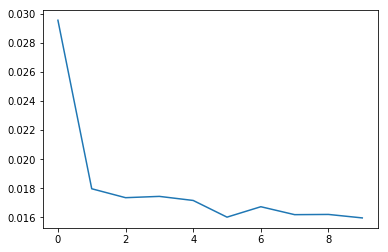

In [316]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [320]:
# evaluate on last batch of training data
first_eval_batch = scaled_train[-n_input:].reshape((1, n_input, 1))
model.predict(first_eval_batch)

array([[0.51337546]], dtype=float32)

In [322]:
# not the worst!
scaled_test[0]

array([0.61441513])

In [324]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, 1))

In [325]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, 1))

for i in range(len(scaled_test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [335]:
np.array(test_predictions).flatten()

array([0.51337546, 0.51553154, 0.4907931 , 0.451852  , 0.4011806 ,
       0.3416463 , 0.28039593, 0.22678706, 0.18784669, 0.16507277,
       0.15596846, 0.15893257, 0.17171755, 0.19293186, 0.22216877,
       0.25670537, 0.2945475 , 0.3359382 , 0.37667918, 0.41498646,
       0.44955388, 0.48070475, 0.5079554 , 0.5325568 , 0.5542117 ,
       0.5724256 , 0.5842816 ], dtype=float32)

In [337]:
results_scaled = pd.DataFrame.from_dict({'y_hat':np.array(test_predictions).flatten(), 'y':np.array(scaled_test).flatten()})
results_scaled

,y_hat,y
0,0.513375,0.614415
1,0.515532,0.483101
2,0.490793,0.295955
3,0.451852,0.122386
4,0.401181,0.275297
5,0.341646,0.397979
6,0.280396,0.360043
7,0.226787,0.375189
8,0.187847,0.141777
9,0.165073,0.259168


In [338]:
true_predictions = scaler.inverse_transform(test_predictions)

In [339]:
results = test_df.copy(deep=True)

In [340]:
results['RNN_pred'] = true_predictions

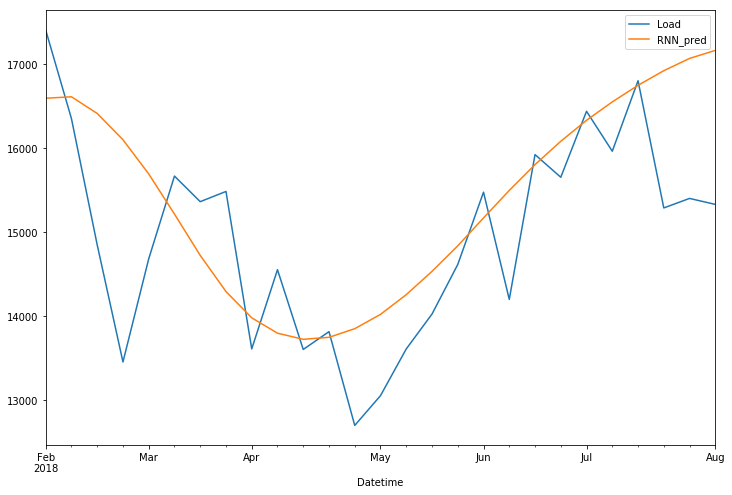

In [341]:
results.plot(figsize=(12,8))

In [343]:
print_metrics(test_df.Load, ES_preds, label='ES Predictions')
print_metrics(test_df.Load, AR_preds, label='AR(19) Predictions')
print_metrics(test_df.Load, ARIMA_preds, label='ARIMA(2,1,2) Predictions')
print_metrics(test_df.Load, SARIMA_preds, label='SARIMA(4, 1, 0)x(0, 0, 2, 52)')
print_metrics(test_df.Load, SARIMA_preds2, label=f'SARIMA{model1.order}x{model1.seasonal_order} Predictions')
print_metrics(test_df.Load, SARIMAX_preds, label=f'SARIMAX Predictions')
print_metrics(test_daily.Load, daily_preds, label=f'SARIMAX Daily-Level Predictions')
print_metrics(results.Load, results.RNN_pred, label=f'RNN Weekly-Level Predictions')

ES Predictions
R2: 0.1899	 MAE: 886.7925	 RMSE: 1056.0728

AR(19) Predictions
R2: 0.2709	 MAE: 863.1265	 RMSE: 1001.8899

ARIMA(2,1,2) Predictions
R2: 0.0419	 MAE: 1003.2365	 RMSE: 1148.5258

SARIMA(4, 1, 0)x(0, 0, 2, 52)
R2: -0.5682	 MAE: 1244.0313	 RMSE: 1469.3779

SARIMA(2, 1, 2)x(1, 1, 1, 52) Predictions
R2: 0.4579	 MAE: 696.5439	 RMSE: 863.9279

SARIMAX Predictions
R2: 0.5415	 MAE: 669.9015	 RMSE: 794.5143

SARIMAX Daily-Level Predictions
R2: 0.1522	 MAE: 1076.7697	 RMSE: 1352.6021

RNN Weekly-Level Predictions
R2: 0.2447	 MAE: 793.1900	 RMSE: 1019.7729



# Conclusions

* Explicit structure -- when it is known -- almost always beats learned structure
* Granularity will always compound error. Comparing a daily-level prediction to a weekly-level prediction is an apples and oranges situation. The face that we have any kind of reasonable predicction for Daily level data that outperforms weekly means is great.
* Performance metrics matter. Look at the difference between the Autoregression algorithm and the RNN. AR outperforms on l2 errors (R^2 and RMSE), which over-penalizes large errors, but RNN outperforms on the l1 error (MAE), which tends to forgive large errors.
